In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# 1. 2D data with Bottleneck

In [90]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, input_size, bottleneck_size, hidden_size, layers):
        '''
        input size: data dim
        bottleneck_size: code dim
        hidden_size: dim of hidden layers, should be larger than input size
        layers: number of hidden layers
        '''
        super().__init__()

        # Encoder
        enc = []
        in_dim = input_size
        for _ in range(layers):
            enc += [nn.Linear(in_dim, hidden_size), nn.ReLU()] 
            in_dim = hidden_size
        enc += [nn.Linear(hidden_size, bottleneck_size)] # output layer
        self.encoder = nn.Sequential(*enc)

        # Decoder 
        dec = []
        in_dim = bottleneck_size
        for _ in range(layers):
            dec += [nn.Linear(in_dim, hidden_size), nn.ReLU()]
            in_dim = hidden_size
        dec += [nn.Linear(hidden_size, input_size)]
        self.decoder = nn.Sequential(*dec)

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out, z


In [91]:
def train_autoencoder(model, X, train_size, batch_size, epochs=50, lr=1e-3):
    '''
    model: AE model
    X: dataset
    '''
    X = torch.tensor(X, dtype=torch.float32)
    
    x_train = X[:train_size]
    x_test = X[train_size:]
    
    # DataLoader 
    train_loader = DataLoader( TensorDataset(x_train), batch_size=batch_size)
    test_loader = DataLoader( TensorDataset(x_test), batch_size=batch_size)
    
    # optimizer
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    # loss
    loss_fn = nn.MSELoss()

    train_losses, test_losses = [], []

    # training loop
    for ep in range(epochs):
        model.train()
        for (x,) in train_loader:      
            opt.zero_grad() # initialize gradient for new epoch
            x_hat, _ = model(x)
            loss = loss_fn(x_hat, x) # mse(x_hat, x)
            loss.backward() 
            opt.step() 
        train_losses.append(loss.item()) # track loss

        model.eval()
        test_loss_total = 0.0
        count = 0
        with torch.no_grad():
            for (x_test_batch,) in test_loader:
                x_hat_test, _ = model(x_test_batch)
                batch_loss = loss_fn(x_hat_test, x_test_batch).item()
                test_loss_total += batch_loss * x_test_batch.size(0)
                count += x_test_batch.size(0)

        test_losses.append(test_loss_total / count)

    return train_losses, test_losses


#### Debug

/var/folders/_3/mcfg84vj1rg_d1rxtct_g2y00000gn/T/ipykernel_54930/1984555381.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float32)


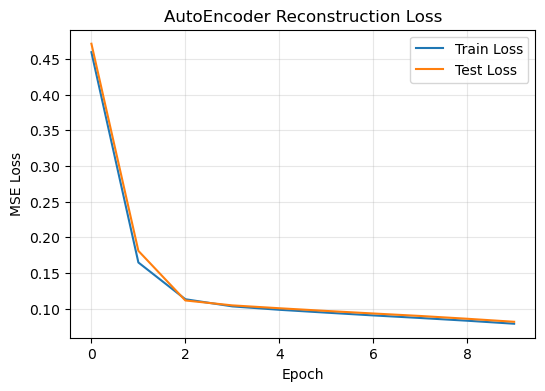

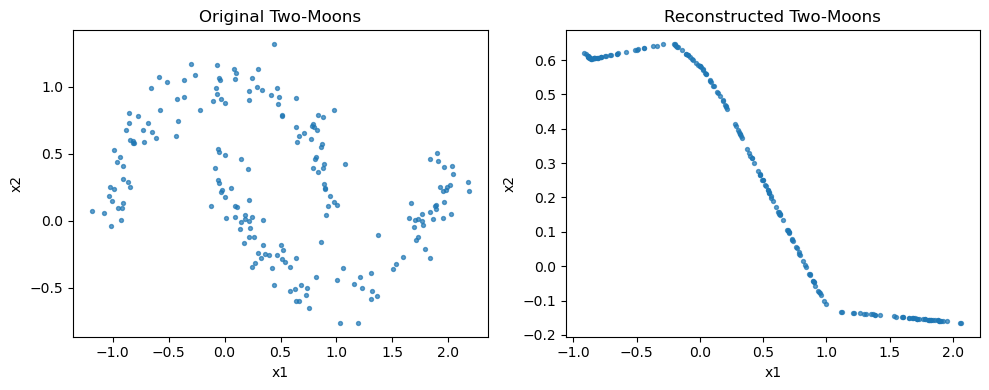

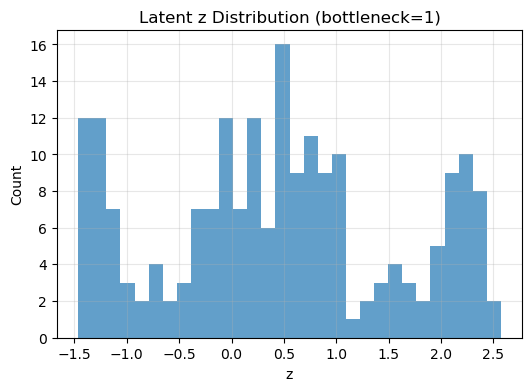

In [92]:
# quick test data
n = 1000
x, _ = make_moons(n_samples=n, noise=0.1)
x = torch.tensor(x, dtype=torch.float32)

# model hyperparameters
input_size = 2
bottleneck_size = 1
hidden_size = 16
layers = 2

model = AutoEncoder(input_size, bottleneck_size, hidden_size, layers)

# training hyperparameters
epochs = 10
lr = 1e-3
batch_size = 16

train_losses, test_losses = train_autoencoder(
    model,
    x,
    train_size=800,
    batch_size=batch_size,
    epochs=epochs,
    lr=lr
)


# Plot result

# loss
plt.figure(figsize=(6,4))
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("AutoEncoder Reconstruction Loss")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


# Reconstructed points plot
model.eval()
with torch.no_grad():
    x_test = x[800:]                     # last 200 samples
    x_hat, z = model(x_test)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.scatter(x_test[:,0], x_test[:,1], s=8, alpha=0.7)
plt.title("Original Two-Moons")
plt.xlabel("x1")
plt.ylabel("x2")

plt.subplot(1,2,2)
plt.scatter(x_hat[:,0], x_hat[:,1], s=8, alpha=0.7)
plt.title("Reconstructed Two-Moons")
plt.xlabel("x1")
plt.ylabel("x2")

plt.tight_layout()
plt.show()


# ===== (3) Latent distribution =====
plt.figure(figsize=(6,4))
plt.hist(z.numpy(), bins=30, alpha=0.7)
plt.title("Latent z Distribution (bottleneck=1)")
plt.xlabel("z")
plt.ylabel("Count")
plt.grid(alpha=0.3)
plt.show()


<div style="color: green; font-weight:
bold">The data points in the original two moons data plot look very spaced out because the number of samples used was only 1000, instead of 10000 like in the solution. However, the general shape is essentially the same as the solution. The reconstructed two-moons data visualization, seems inaccurate. This could be because of underfitting. The number of epochs used to train the model was only 10 which wasn't enough to train the model properly.</div>

#### Hyperparameters test

In [93]:
hidden_sizes = [4, 8, 16, 32]
layers_list = [2,4,6]
learning_rates = [1e-2, 1e-3, 1e-4]
batch_sizes=[16,32,64,128]

results = {}  # {(hidden,layers,lr): test_loss}

for hidden_size in hidden_sizes:
    for layers in layers_list:
        for lr in learning_rates:
            for batch in batch_sizes:

                print(f"Running: hidden={hidden_size}, layers={layers}, lr={lr}, batch={batch}")

                model = AutoEncoder(
                    input_size=2,
                    bottleneck_size=1,
                    hidden_size=hidden_size,
                    layers=layers
                )

                train_losses, test_losses = train_autoencoder(
                    model,
                    x,
                    train_size=800,
                    batch_size=batch,
                    epochs=30,
                    lr=lr
                )

                final_test_loss = test_losses[-1]
                results[(hidden_size, layers, lr, batch)] = final_test_loss

Running: hidden=4, layers=2, lr=0.01, batch=16


/var/folders/_3/mcfg84vj1rg_d1rxtct_g2y00000gn/T/ipykernel_54930/1984555381.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float32)


Running: hidden=4, layers=2, lr=0.01, batch=32
Running: hidden=4, layers=2, lr=0.01, batch=64
Running: hidden=4, layers=2, lr=0.01, batch=128
Running: hidden=4, layers=2, lr=0.001, batch=16
Running: hidden=4, layers=2, lr=0.001, batch=32
Running: hidden=4, layers=2, lr=0.001, batch=64
Running: hidden=4, layers=2, lr=0.001, batch=128
Running: hidden=4, layers=2, lr=0.0001, batch=16
Running: hidden=4, layers=2, lr=0.0001, batch=32
Running: hidden=4, layers=2, lr=0.0001, batch=64
Running: hidden=4, layers=2, lr=0.0001, batch=128
Running: hidden=4, layers=4, lr=0.01, batch=16
Running: hidden=4, layers=4, lr=0.01, batch=32
Running: hidden=4, layers=4, lr=0.01, batch=64
Running: hidden=4, layers=4, lr=0.01, batch=128
Running: hidden=4, layers=4, lr=0.001, batch=16
Running: hidden=4, layers=4, lr=0.001, batch=32
Running: hidden=4, layers=4, lr=0.001, batch=64
Running: hidden=4, layers=4, lr=0.001, batch=128
Running: hidden=4, layers=4, lr=0.0001, batch=16
Running: hidden=4, layers=4, lr=0.000

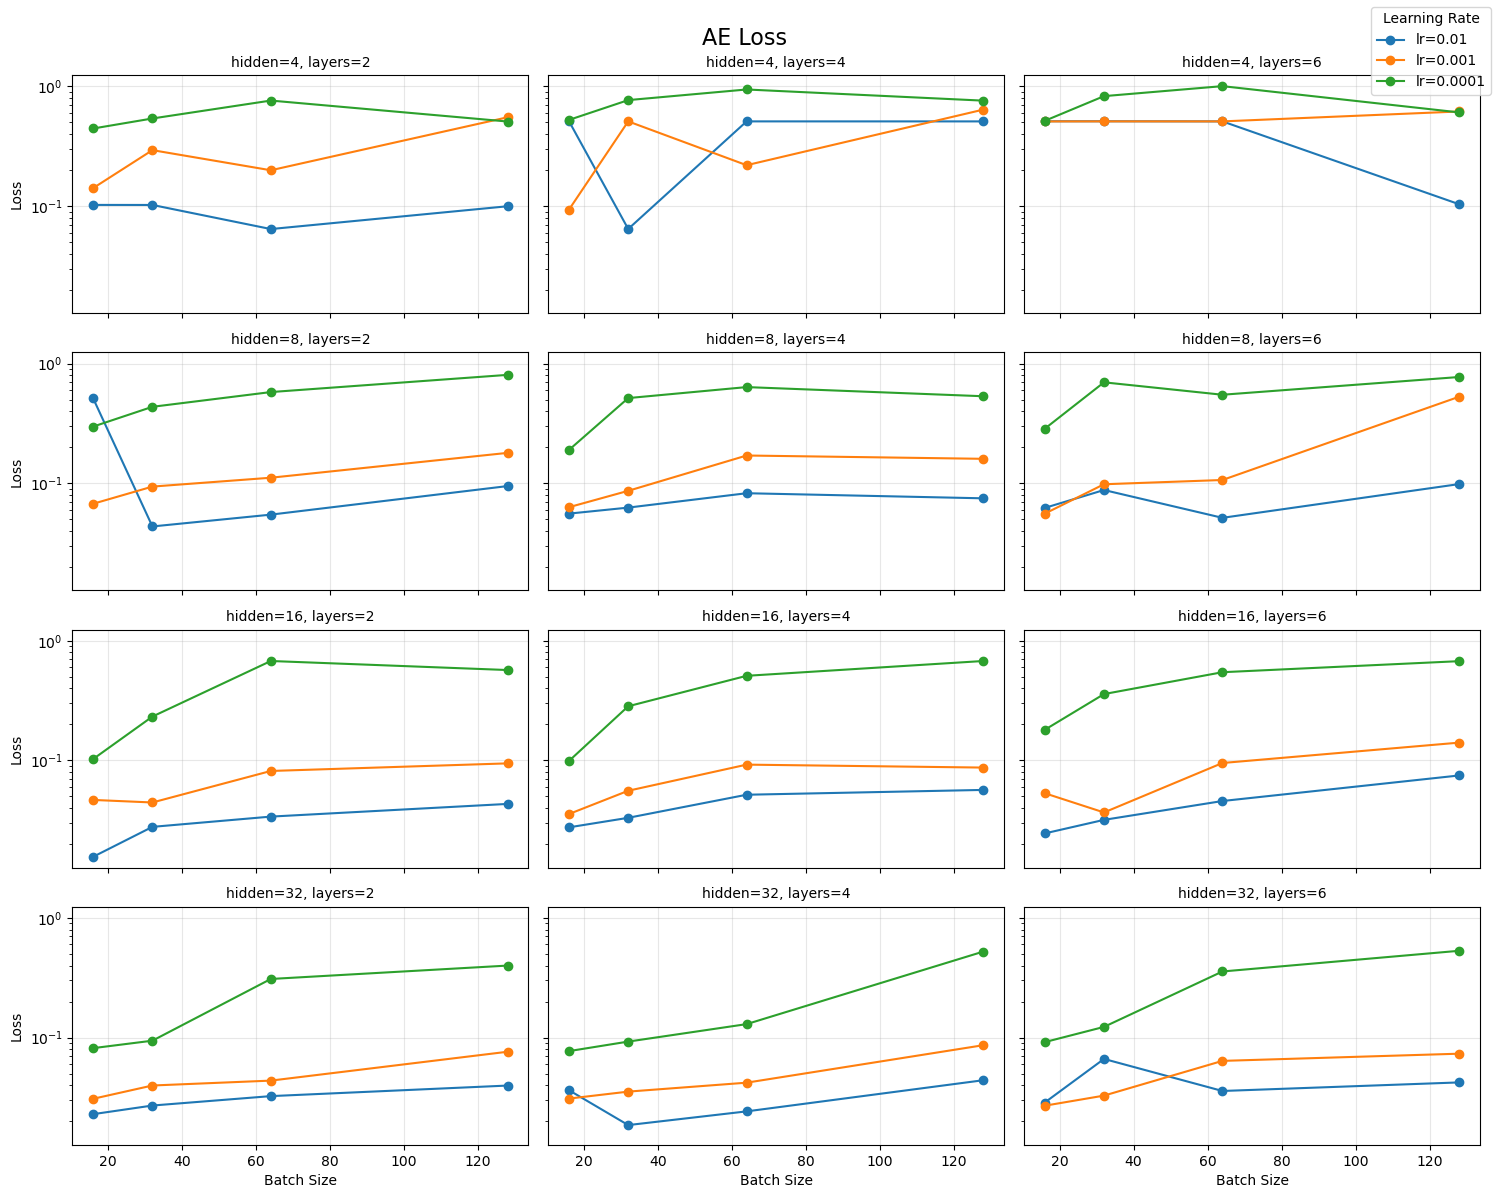

In [94]:
# subplot grid
fig, axes = plt.subplots(
    len(hidden_sizes), len(layers_list),
    figsize=(15, 12),
    sharex=True, sharey=True
)

for i, hidden in enumerate(hidden_sizes):
    for j, layers in enumerate(layers_list):
        
        ax = axes[i, j]
        
        for lr in learning_rates:
            losses = [
                results[(hidden, layers, lr, batch)]
                for batch in batch_sizes
            ]
            
            ax.plot(batch_sizes, losses, marker='o', label=f"lr={lr}")

        ax.set_title(f"hidden={hidden}, layers={layers}", fontsize=10)
        ax.grid(alpha=0.3)
        ax.set_yscale('log')

axes[3,0].set_xlabel('Batch Size')
axes[3,1].set_xlabel('Batch Size')
axes[3,2].set_xlabel('Batch Size')

axes[0,0].set_ylabel('Loss')
axes[1,0].set_ylabel('Loss')
axes[2,0].set_ylabel('Loss')
axes[3,0].set_ylabel('Loss')

# legend outside right
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', title="Learning Rate")

plt.suptitle("AE Loss", fontsize=16)
plt.tight_layout()
plt.show()



<div style="color: green; font-weight:
bold">Many models are being trained which drastically increases runtime. This is inefficient. Iit would be better to use random search or implement early stopping so that the model stops training if it sees no improvement (which would reduce runtime).</div>

Best performance: 
- Batch size: 32
- LR: 0.01
- Hidden size: 16
- Layers: 4

#### Repeat

/var/folders/_3/mcfg84vj1rg_d1rxtct_g2y00000gn/T/ipykernel_54930/1984555381.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float32)


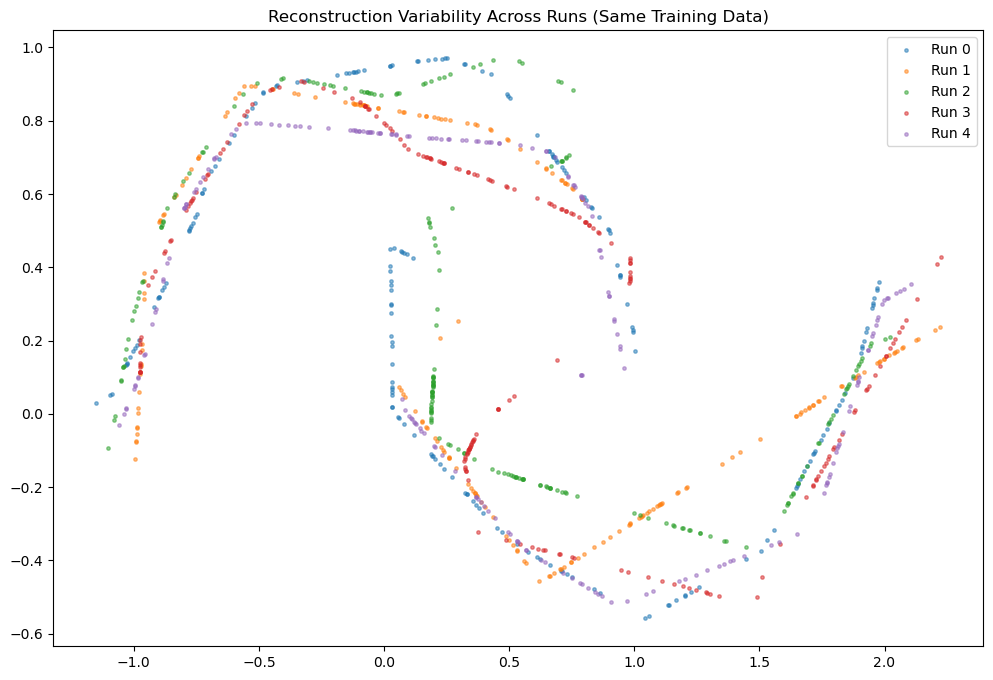

In [95]:
best_params = dict(hidden=16, layers=4, batch=32, lr=1e-2)

models = []
reconstructions = []
z_list = []

for seed in [0,1,2,3,4]:
    torch.manual_seed(seed)

    model = AutoEncoder(2, 1, best_params["hidden"], best_params["layers"])
    train_losses, test_losses = train_autoencoder(
        model, x, train_size=800,
        batch_size=best_params["batch"],
        epochs=50,
        lr=best_params["lr"]
    )

    model.eval()
    with torch.no_grad():
        x_test = x[800:]
        x_hat, z = model(x_test)

    reconstructions.append(x_hat.numpy())
    z_list.append(z.numpy())
    models.append(model)

plt.figure(figsize=(12,8))
for i in range(5):
    plt.scatter(reconstructions[i][:,0], reconstructions[i][:,1], s=6, alpha=0.5, label=f"Run {i}")
plt.title("Reconstruction Variability Across Runs (Same Training Data)")
plt.legend()
plt.show()



<div style="color: green; font-weight:
bold"> This plot includes many reconstruction visualizations from the sample solution.</div>

Across five independent training runs with the same dataset and hyperparameters, the reconstructions show noticeable variability. Because the bottleneck dimension is only 1, the autoencoder is forced to compress the two-dimensional manifold into a single latent coordinate, which is highly information-restrictive. As a result, the model tends to learn different one-dimensional parametrizations of the data in each run, leading to run-to-run variations in local geometry (e.g., stretching, bending, and misalignment of segments).

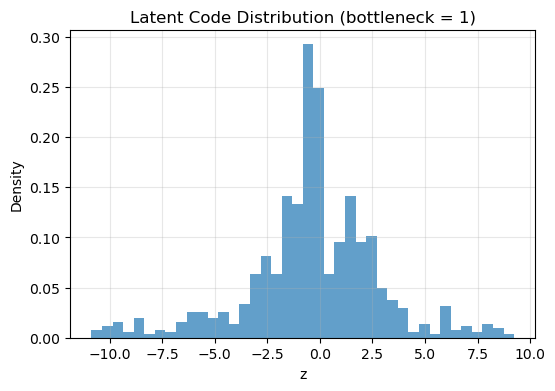

In [97]:
z_all = np.concatenate(z_list)  # shape (N*5, 1)

plt.figure(figsize=(6,4))
plt.hist(z_all, bins=40, density=True, alpha=0.7)
plt.title("Latent Code Distribution (bottleneck = 1)")
plt.xlabel("z")
plt.ylabel("Density")
plt.grid(alpha=0.3)
plt.show()

#### Noise level 0.2

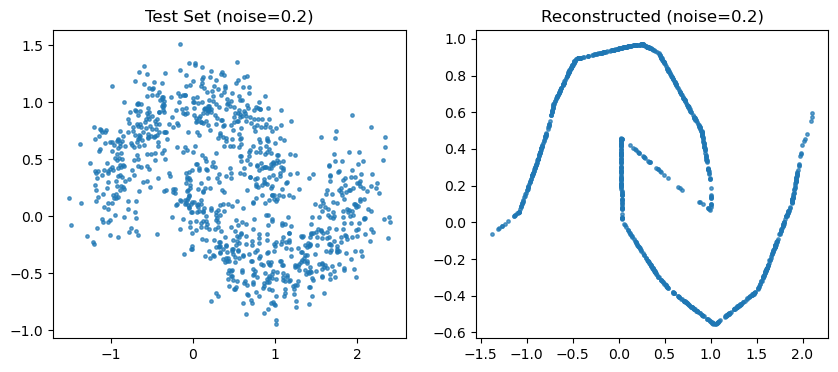

In [96]:
x_noise2, _ = make_moons(n_samples=1000, noise=0.2)
x_noise2 = torch.tensor(x_noise2, dtype=torch.float32)

model = models[0]

model.eval()
with torch.no_grad():
    x_hat_noise2, _ = model(x_noise2)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.scatter(x_noise2[:,0], x_noise2[:,1], s=6, alpha=0.7)
plt.title("Test Set (noise=0.2)")

plt.subplot(1,2,2)
plt.scatter(x_hat_noise2[:,0], x_hat_noise2[:,1], s=6, alpha=0.7)
plt.title("Reconstructed (noise=0.2)")

plt.show()


At noise level 0.2, the autoencoder no longer reconstructs the two-moons structure faithfully. The output collapses into a distorted 1-D trajectory with noticeable artifacts. However, the model still preserves a coarse global outline of the moons, indicating that some aspects of the underlying geometry are retained despite the higher noise.

#### GMM

<div style="color: green; font-weight:
bold">The test set with noise = 0.2 and the reconstrcted data plot are essentially equal to the solution.</div>

# 2. 2D data without bottleneck

#### Define MMD

In [3]:
## From last HW (sample solution)
def squared_exponential_kernel(x1, x2, h):
    # x1: (N, d), x2: (M, d)
    x1 = x1.unsqueeze(1)  # (N,1,d)
    x2 = x2.unsqueeze(0)  # (1,M,d)
    squared_dist = ((x1 - x2)**2).sum(dim=-1) / (h**2)
    return torch.exp(-squared_dist)

def inverse_multi_quadratic_kernel(x1, x2, h):
    x1 = x1.unsqueeze(1)  # (N,1,d)
    x2 = x2.unsqueeze(0)  # (1,M,d)
    squared_dist = ((x1 - x2)**2).sum(dim=-1) / (h**2)
    return 1.0 / torch.sqrt(1.0 + squared_dist)

def mmd2(X_true, X_pred, kernel, h):
    k_xx = kernel(X_true, X_true, h).mean()
    k_yy = kernel(X_pred, X_pred, h).mean()
    k_xy = kernel(X_true, X_pred, h).mean()
    return k_xx + k_yy - 2 * k_xy


    

#### ResNet AutoEncoder

In [4]:
class ResidualBlock(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.f = nn.Sequential( # f_l
            nn.Linear(dim, hidden_dim), # hidden dim > input dim
            nn.ReLU(),
            nn.Linear(hidden_dim, dim)  # output dim = input dim
        )

    def forward(self, x):
        return x + self.f(x)
    

class ResNetEncoder(nn.Module):
    def __init__(self, bottleneck_dim, input_dim, hidden_dim, num_blocks):
        '''
        input_dim: z_0 (original data) dim
        bottelneck_dim: 2
        hidden_dim: hidden_dim > input_dim
        num_blocks: L
        '''
        super().__init__()

        # first projection to hidden dim
        self.input_layer = nn.Linear(input_dim, hidden_dim) 

        # L residual blocks
        self.resblocks = nn.ModuleList([
            ResidualBlock(hidden_dim, hidden_dim) 
            for _ in range(num_blocks)
        ])

        # project down to bottleneck
        self.output_layer = nn.Linear(hidden_dim, bottleneck_dim)

    def forward(self, x):
        h = self.input_layer(x)
        for block in self.resblocks:
            h = block(h)
        z = self.output_layer(h)
        return z

class ResNetDecoder(nn.Module):
    def __init__(self, bottleneck_dim, output_dim, hidden_dim, num_blocks):
        super().__init__()

        self.input_layer = nn.Linear(bottleneck_dim, hidden_dim)

        self.resblocks = nn.ModuleList([
            ResidualBlock(hidden_dim, hidden_dim)
            for _ in range(num_blocks)
        ])

        self.output_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, z):
        h = self.input_layer(z)
        for block in self.resblocks:
            h = block(h)
        x_hat = self.output_layer(h)
        return x_hat


class ResNetAutoEncoder(nn.Module):
    def __init__(self, input_dim, bottleneck_dim, hidden_dim, num_blocks):
        super().__init__()

        self.encoder = ResNetEncoder(input_dim, bottleneck_dim, hidden_dim, num_blocks)
        self.decoder = ResNetDecoder(bottleneck_dim, input_dim, hidden_dim, num_blocks)

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z

<div style="color: green; font-weight:
bold">Accidentally put  ResNetEncoder(input_dim, bottleneck_dim, hidden_dim, num_blocks) instead of  ResNetEncoder( bottleneck_dim, input_dim, hidden_dim, num_blocks) which could explain why data was encoded incorrectly.</div>

### Train Model

In [5]:
def train_res_autoencoder(
    model,
    X,
    train_size,
    batch_size=128,
    epochs=150,
    lr=1e-3,
    lambda_mmd=1e-2,
    kernel=inverse_multi_quadratic_kernel,
    bandwidths=[0.1, 0.2, 0.4, 0.8, 1.6]
):
    if isinstance(X, np.ndarray):
        X = torch.tensor(X, dtype=torch.float32)

    device = next(model.parameters()).device
    X = X.to(device)

    x_train = X[:train_size]
    x_test  = X[train_size:]

    train_loader = DataLoader(
        TensorDataset(x_train),
        batch_size=batch_size,
        shuffle=True
    )
    test_loader = DataLoader(
        TensorDataset(x_test),
        batch_size=batch_size,
        shuffle=False
    )

    opt = torch.optim.Adam(model.parameters(), lr=lr)
    mse = nn.MSELoss()

    train_loss, train_mmd_vals = [], []
    test_loss, test_mmd_vals = [], []

    for ep in range(epochs):
        model.train()
        recon_sum, mmd_sum, n_sum = 0, 0, 0

        for (batch,) in train_loader:
            batch = batch.to(device)

            opt.zero_grad()

            x_hat, z = model(batch)
            prior = torch.randn_like(z)

            # reconstruction
            recon_loss = mse(x_hat, batch)

            # multi-scale MMD
            mmd_loss = 0
            for h in bandwidths:
                mmd_loss += mmd2(z, prior, kernel, h)

            loss = recon_loss + lambda_mmd * mmd_loss
            loss.backward()
            opt.step()

            bs = batch.size(0)
            recon_sum += recon_loss.item() * bs
            mmd_sum   += mmd_loss.item() * bs
            n_sum     += bs

        train_loss.append(recon_sum / n_sum)
        train_mmd_vals.append(mmd_sum / n_sum)

        # ----- test -----
        model.eval()
        recon_sum, mmd_sum, n_sum = 0, 0, 0
        with torch.no_grad():
            for (batch,) in test_loader:
                batch = batch.to(device)

                x_hat, z = model(batch)
                prior = torch.randn_like(z)

                recon_loss = mse(x_hat, batch)

                mmd_loss = 0
                for h in bandwidths:
                    mmd_loss += mmd2(z, prior, kernel, h)

                bs = batch.size(0)
                recon_sum += recon_loss.item() * bs
                mmd_sum   += mmd_loss.item() * bs
                n_sum     += bs

        test_loss.append(recon_sum / n_sum)
        test_mmd_vals.append(mmd_sum / n_sum)

        if (ep+1) % 20 == 0:
            print(f"epoch [{ep+1}] recon loss={train_loss[-1]:.8f}, mmd={train_mmd_vals[-1]:.4f}")

    return train_loss, train_mmd_vals, test_loss, test_mmd_vals


#### Performance Bottleneck = 2

In [84]:
# load data
n = 4000
x_np, _ = make_moons(n_samples=n, noise=0.1)
x = torch.tensor(x_np, dtype=torch.float32)

# model
res_model = ResNetAutoEncoder(
    input_dim=2,
    bottleneck_dim=2,
    hidden_dim=32,
    num_blocks=4
)

# train and evaluate model
train_loss_res, train_mmd_rec, test_loss_res, test_mmd_res = train_res_autoencoder(
    res_model,
    x,
    train_size=3000,
    batch_size=128,
    epochs=150,
    lr=1e-3,
    lambda_mmd=1e-1,
    kernel=inverse_multi_quadratic_kernel,
    bandwidths=[ 0.1, 0.2, 0.4, 0.8, 1.6, 3.2]
)

epoch [20] recon loss=0.00025999, mmd=0.0909
epoch [40] recon loss=0.00025980, mmd=0.0805
epoch [60] recon loss=0.00037737, mmd=0.0684
epoch [80] recon loss=0.00039491, mmd=0.0699
epoch [100] recon loss=0.00037673, mmd=0.0601
epoch [120] recon loss=0.00031833, mmd=0.0585
epoch [140] recon loss=0.00040152, mmd=0.0640


#### Performance Bottleneck=1

In [85]:
# load data
n = 4000
x_np, _ = make_moons(n_samples=n, noise=0.1)
x = torch.tensor(x_np, dtype=torch.float32)

x_train = x[:3600]
# model
model = AutoEncoder(
    input_size=2,
    bottleneck_size=1,
    hidden_size=16,
    layers=4
)

# train and evaluate model
train_loss_1, test_loss_1 = train_autoencoder(
    model,
    x,
    train_size=3600,
    batch_size=16,
    epochs=150,
    lr=1e-3
)

x_test = x[3600:]
x_hat, z = model(x)

# mmd_AE1 = mmd2(x_test, x_hat, inverse_multi_quadratic_kernel, 0.1)

/var/folders/_3/mcfg84vj1rg_d1rxtct_g2y00000gn/T/ipykernel_54930/1984555381.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float32)


#### Loss Bottleneck 1 vs 2

Text(0.5, 1.0, 'AE Bottleneck 1 vs 2')

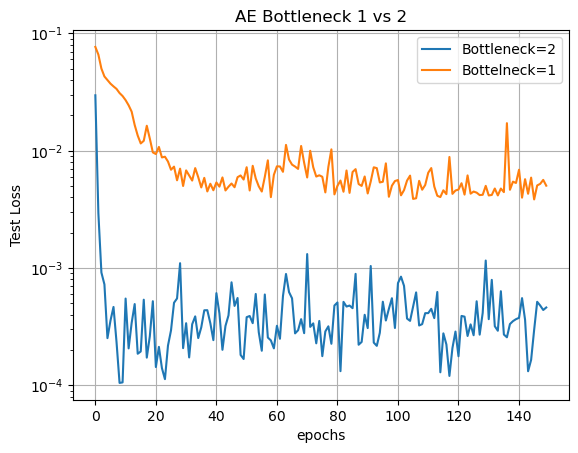

In [86]:
# plt.figure(figsize=(10,4))

# plt.subplot(1,2,1)
plt.plot(range(150), test_loss_res, label= 'Bottleneck=2')
plt.plot(range(150), train_loss_1, label= 'Bottelneck=1')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('Test Loss')
plt.grid()
plt.yscale('log')

# plt.subplot(1,2,2)
# plt.plot(range(150), test_mmd_res, label= 'Bottleneck=2')
# plt.plot(range(150), mmd_AE1, label= 'Bottelneck=1')
# plt.legend()
# plt.xlabel('epochs')
# plt.ylabel('MMD Recon vs Data')
# plt.grid()
# plt.yscale('log')

plt.title('AE Bottleneck 1 vs 2')

#### Visualization

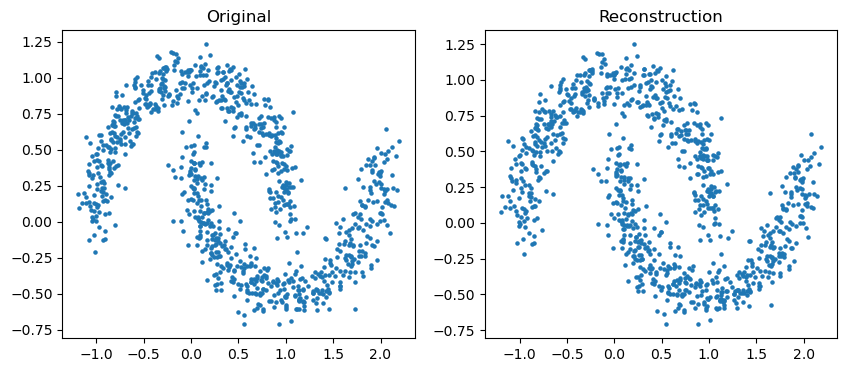

In [87]:
model.eval()
with torch.no_grad():
    x_test = x[3000:]
    x_hat, z = res_model(x_test)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(x_test[:,0], x_test[:,1], s=5)
plt.title("Original")

plt.subplot(1,2,2)
plt.scatter(x_hat[:,0], x_hat[:,1], s=5)
plt.title("Reconstruction")

plt.show()


#### Synthetic data

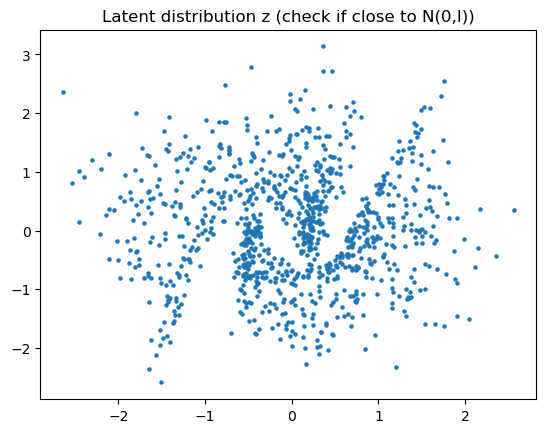

In [88]:
with torch.no_grad():
    z = res_model.encoder(x_test)

z_np = z.cpu().numpy()
plt.scatter(z_np[:,0], z_np[:,1], s=5)
plt.title("Latent distribution z (check if close to N(0,I))")
plt.show()


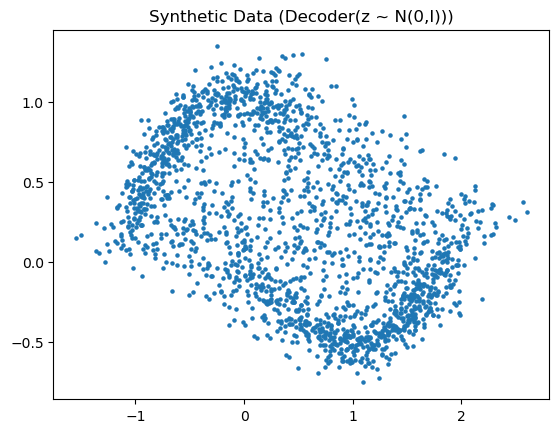

In [89]:

# synthetic data
with torch.no_grad():
    z = torch.randn(2000, 2)
    x_synth = res_model.decoder(z)

plt.scatter(x_synth[:,0], x_synth[:,1], s=5)
plt.title("Synthetic Data (Decoder(z ~ N(0,I)))")
plt.show()

<div style="color: green; font-weight:
bold">The synthetic data plot looks like the generated data after 40 epochs plot provided in the solution.</div>

Our ResNetAutoEncoder with bottleneck dim=2 results in lower test loss than bottleneck dim=1 case, and reconstruts the two moon dataset well. The latent distribution produced by the encoder approximates the standard normal distributions: centered at 0, overall round distributions, but still with 2 clusters presenting. The synthetic distribution produced by the decoder also approximates the two moon datasets, with points clustering around two moons shape, but still slightly connected.

<div style="color: green; font-weight:
bold">Overall, there are a few things missing but the code still provides basic autoencoder training, visualizations of reconstructions, created the two moons dataset, and showed what the data looks like when noise = 0.2. 
Ways to improve: include more visualizations, the histogram should have two clear separated modes, one for each moon and the amount of models being trained should be decreased to reduce runtime. </div>